# Proyecto Primera Entrega

In [ ]:
# Importamos librerías

import requests
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTENC
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Definimos api key, game name y tag line

gameName = "UwU OwO Arf Arf"
tagLine = "LAN"
region = "americas"
api_key = "RGAPI-9e3ec05e-1ee0-43f6-aa5c-ec63f6fdd3f0"
request_url = "https://americas.api.riotgames.com/riot/account/v1/accounts/by-riot-id/"+gameName + "/" + tagLine
api_url = request_url + '?api_key=' + api_key
print(api_url)

resp = requests.get(api_url)
player_info = resp.json()
player_info

puuid = player_info.get('puuid')
print(puuid)

In [ ]:
# Con la url de las partidas empezamos a recopilar los IDs

match_url = "https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/" + puuid + "/ids?type=ranked&start=0&count=20"
match_url = match_url + "&api_key=" + api_key
match_url

In [ ]:
# Empezamos a recolectar la información pertinente a las partidas que vamos a analizar

match_count = 100

def get_match_data(region, match_id, api_key):
    api_url = (
        f"https://{region}.api.riotgames.com/lol/match/v5/matches/{match_id}"
        f"?api_key={api_key}"
    )

    while True:
        resp = requests.get(api_url)
        if resp.status_code == 429:
            print("Rate limit exceeded. Sleeping for 10 seconds...")
            time.sleep(10)
            continue
        elif resp.status_code != 200:
            print(f"Error fetching match data for {match_id}: {resp.status_code}")
            return None
        else:
            break

    return resp.json()

def get_matches(region, puuid, count, api_key):
    api_url = (
        f"https://{region}.api.riotgames.com/lol/match/v5/matches/by-puuid/"
        f"{puuid}/ids?start=0&count={count}&api_key={api_key}"
    )

    resp = requests.get(api_url)
    if resp.status_code != 200:
        print("Error fetching matches:", resp.status_code)
        return []
    return resp.json()

matches = get_matches(region, puuid, match_count, api_key)

match_results = {}

for idx, match_id in enumerate(matches, start=1):
    print(f"Fetching data for match {idx}: {match_id}")
    match_data = get_match_data(region, match_id, api_key)

    if match_data is None:
        continue

    try:
        part_index = match_data['metadata']['participants'].index(puuid)
        participant_data = match_data['info']['participants'][part_index]
    except ValueError:
        print(f"Player not found in match {match_id}")
        continue

    total_farm = participant_data.get('totalMinionsKilled', 0) + participant_data.get('neutralMinionsKilled', 0)

    match_results[match_id] = {
        'win': participant_data['win'],
        'championName': participant_data['championName'],
        'kills': participant_data['kills'],
        'deaths': participant_data['deaths'],
        'assists': participant_data['assists'],
        'gameDuration': match_data['info'].get('gameDuration'),
        'totalMinionsKilled': participant_data.get('totalMinionsKilled'),
        'neutralMinionsKilled': participant_data.get('neutralMinionsKilled', 0),
        'totalFarm': total_farm,
        'totalDamageDealtToChampions': participant_data.get('totalDamageDealtToChampions'),
        'wardsPlaced': participant_data.get('wardsPlaced'),
        'wardsDestroyed': participant_data.get('wardsDestroyed'),
        'dragonKills': participant_data.get('dragonKills'),
        'baronKills': participant_data.get('baronKills'),
        'turretTakedowns': participant_data.get('turretTakedowns'),
        'firstBloodKill': participant_data.get('firstBloodKill'),
        'firstTowerKill': participant_data.get('firstTowerKill'),
        'firstBaron': participant_data.get('firstBaron'),
        'firstDragon': participant_data.get('firstDragon')
    }

    time.sleep(2.5)

df = pd.DataFrame.from_dict(match_results, orient='index')
print(df)

In [ ]:
match_data['info']

In [ ]:
# Imprimimos las columnas con los nombres de las variables a analizar
print(df.columns)

In [ ]:
numeric_df = df.select_dtypes(include=[np.number])
print("Descriptive statistics for numeric columns:")
print(numeric_df.describe())

# Grouping by championName and including 'totalFarm' in the aggregation
champion_stats = df.groupby('championName').agg({
    'win': ['count', 'sum'],
    'kills': 'mean',
    'deaths': 'mean',
    'assists': 'mean',
    'gameDuration': 'mean',
    'totalMinionsKilled': 'mean',
    'neutralMinionsKilled': 'mean',
    'totalFarm': 'mean',  # Including totalFarm in aggregation
    'totalDamageDealtToChampions': 'mean',
    'wardsPlaced': 'mean',
    'wardsDestroyed': 'mean',
    'dragonKills': 'mean',
    'baronKills': 'mean',
    'turretTakedowns': 'mean',
    'firstBloodKill': 'mean',
    'firstTowerKill': 'mean',
    'firstBaron': 'mean',
    'firstDragon': 'mean'
})

# Flatten multi-level columns after aggregation
champion_stats.columns = [
    'matches', 'wins', 'avg_kills', 'avg_deaths', 'avg_assists', 'avg_gameDuration',
    'avg_minions', 'avg_neutralMinions', 'avg_totalFarm', 'avg_damage', 'avg_wardsPlaced',
    'avg_wardsDestroyed', 'avg_dragonKills', 'avg_baronKills', 'avg_turretTakedowns',
    'avg_firstBloodKill', 'avg_firstTowerKill', 'avg_firstBaron', 'avg_firstDragon'
]

# Adding win rate column
champion_stats['win_rate'] = champion_stats['wins'] / champion_stats['matches'] * 100

print("Descriptive statistics for champion stats:")
print(champion_stats.describe())

print("Champion stats aggregated by championName:")
print(champion_stats)

In [ ]:
# Matriz de correlación
correlation_matrix = df.corr(numeric_only=True)
print(correlation_matrix)

In [ ]:
# Gráficamos los datos

numeric_stats = numeric_df.describe().T
numeric_stats['std'] = numeric_df.std()
numeric_stats['mode'] = numeric_df.mode().iloc[0]
numeric_stats['median'] = numeric_df.median()

numeric_stats['mean_plus_std'] = numeric_stats['mean'] + numeric_stats['std']
numeric_stats['mean_minus_std'] = numeric_stats['mean'] - numeric_stats['std']

stats = ['mean', 'std', 'mode', 'median', 'mean_plus_std', 'mean_minus_std']
stats_values = []

for stat in stats:
    stats_values.append(numeric_stats[stat].values)

plt.figure(figsize=(12, 6))
x_labels = numeric_stats.index
for i, stat in enumerate(stats):
    plt.plot(x_labels, stats_values[i], label=stat, marker='o')

plt.title('Mean, Std, Mode, Median, Mean+Std, and Mean-Std for Numeric Columns')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(title='Statistics')
plt.tight_layout()
plt.show()

# Boxplot to visualize the distribution of numeric columns
plt.figure(figsize=(12, 6))
sns.boxplot(data=numeric_df)
plt.title('Boxplot for Numeric Columns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

if 'kills' in df.columns:
    plt.figure(figsize=(8, 6))
    plt.hist(df['kills'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Kills')
    plt.xlabel('Kills')
    plt.ylabel('Frequency')
    plt.show()

plt.figure(figsize=(8, 6))
if 'kills' in df.columns and 'deaths' in df.columns and 'win' in df.columns:
    scatter = plt.scatter(df['kills'], df['deaths'], alpha=0.6,
                          c=df['win'].astype(int), cmap='coolwarm')
    plt.title('Kills vs. Deaths (Win/Loss)')
    plt.xlabel('Kills')
    plt.ylabel('Deaths')
    plt.colorbar(scatter, label='Win (1) / Loss (0)')
    plt.show()

champ_stats_reset = champion_stats.reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='championName', y='win_rate', data=champ_stats_reset, palette='viridis')
plt.title('Win Rate per Champion')
plt.xlabel('Champion')
plt.ylabel('Win Rate (%)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 8))
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df['totalFarm'], df['kills'], alpha=0.7, c='b', edgecolors='w', s=100)
plt.title("Total Farm vs Kills")
plt.xlabel("Total Farm")
plt.ylabel("Kills")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
df_merged = pd.merge(df, champion_stats, on='championName', how='left')

# New features for League of Legends dataset
df_merged['KDA'] = (df_merged['kills'] + df_merged['assists']) / (df_merged['deaths'].replace(0, 1e-9) + 1e-9)
df_merged['minionsPerMinute'] = df_merged['totalMinionsKilled'] / (df_merged['gameDuration'] / 60)
df_merged['damagePerMinute'] = df_merged['totalDamageDealtToChampions'] / (df_merged['gameDuration'] / 60)
df_merged['firstObjectiveCount'] = df_merged[['firstBloodKill', 'firstTowerKill', 'firstBaron', 'firstDragon']].sum(axis=1)
df_merged['wardScore'] = df_merged['wardsPlaced'] + 2 * df_merged['wardsDestroyed']
df_merged['highDeaths'] = (df_merged['deaths'] > 10).astype(int)
df_merged['gamePhase'] = pd.cut(df_merged['gameDuration'],
                                bins=[0, 1500, 2500, 9999],  # 0-25m, 25-41m, 41m+
                                labels=['Early', 'Mid', 'Late'])
df_merged['killsXdamage'] = df_merged['kills'] * df_merged['totalDamageDealtToChampions']
df_merged['deathsXassists'] = df_merged['deaths'] * df_merged['assists']

In [ ]:
numeric_cols = df_merged.select_dtypes(include=["number"]).columns.tolist()
for col in numeric_cols:
    if df_merged[col].isnull().sum() > 0:
        df_merged[col].fillna(df_merged[col].median(), inplace=True)

In [ ]:
categorical_cols = df_merged.select_dtypes(include=["object"]).columns.tolist()
for col in categorical_cols:
    if df_merged[col].isnull().sum() > 0:
        mode_val = df_merged[col].mode()
        if not mode_val.empty:
            df_merged[col].fillna(mode_val.iloc[0], inplace=True)
        else:
            # Optionally, fill with a default value if no mode is found
            df_merged[col].fillna("Unknown", inplace=True)

In [ ]:
def outlier_thresholds(dataframe, variable, low_quantile=0.05, up_quantile=0.95):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

In [ ]:
def has_outliers(dataframe, numeric_columns, plot=False):
    for col in numeric_columns:
        low_limit, up_limit = outlier_thresholds(dataframe, col)
        outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)]
        if not outliers.empty:
            print(f"{col}: {outliers.shape[0]} outliers")
            if plot:
                sns.boxplot(x=dataframe[col])
                plt.title(f"Boxplot for {col}")
                plt.show()

In [ ]:
for col in numeric_cols:
    has_outliers(df_merged, [col], plot=False)

In [ ]:
X = df_merged.drop([
    'win',               # target variable
    'championName',      # identifier
    'gameDuration',      # used for feature engineering
    'win_rate',          # meta-information
    'wins',
    'totalFarm',
    'damagePerMinute',   # engineered features can be dropped if desired
    'firstObjectiveCount',
    'wardScore',
    'firstDragon',
    'firstBaron',
    'firstTowerKill',
    'firstBloodKill'
], axis=1)
y = df_merged['win']

In [ ]:
scaler = StandardScaler()
numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Merge dataframes (df and champion_stats must be defined earlier)
df_merged = pd.merge(df, champion_stats, on='championName', how='left')

# Feature engineering for League of Legends dataset
df_merged['KDA'] = (df_merged['kills'] + df_merged['assists']) / (df_merged['deaths'].replace(0, 1e-9) + 1e-9)
df_merged['minionsPerMinute'] = df_merged['totalMinionsKilled'] / (df_merged['gameDuration'] / 60)
df_merged['damagePerMinute'] = df_merged['totalDamageDealtToChampions'] / (df_merged['gameDuration'] / 60)
df_merged['firstObjectiveCount'] = df_merged[['firstBloodKill', 'firstTowerKill', 'firstBaron', 'firstDragon']].sum(axis=1)
df_merged['wardScore'] = df_merged['wardsPlaced'] + 2 * df_merged['wardsDestroyed']
df_merged['highDeaths'] = (df_merged['deaths'] > 10).astype(int)
df_merged['gamePhase'] = pd.cut(df_merged['gameDuration'],
                                bins=[0, 1500, 2500, 9999],  # 0-25m, 25-41m, 41m+
                                labels=['Early', 'Mid', 'Late'])
df_merged['killsXdamage'] = df_merged['kills'] * df_merged['totalDamageDealtToChampions']
df_merged['deathsXassists'] = df_merged['deaths'] * df_merged['assists']

# Fill missing values for numeric features with the median
numeric_cols = df_merged.select_dtypes(include=["number"]).columns.tolist()
for col in numeric_cols:
    if df_merged[col].isnull().sum() > 0:
        df_merged[col].fillna(df_merged[col].median(), inplace=True)

# Fill missing values for categorical features with the mode or 'Unknown'
categorical_cols = df_merged.select_dtypes(include=["object"]).columns.tolist()
for col in categorical_cols:
    if df_merged[col].isnull().sum() > 0:
        mode_val = df_merged[col].mode()
        if not mode_val.empty:
            df_merged[col].fillna(mode_val.iloc[0], inplace=True)
        else:
            df_merged[col].fillna("Unknown", inplace=True)

# Outlier helper functions
def outlier_thresholds(dataframe, variable, low_quantile=0.05, up_quantile=0.95):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

def has_outliers(dataframe, numeric_columns, plot=False):
    for col in numeric_columns:
        low_limit, up_limit = outlier_thresholds(dataframe, col)
        outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)]
        if not outliers.empty:
            print(f"{col}: {outliers.shape[0]} outliers")
            if plot:
                sns.boxplot(x=dataframe[col])
                plt.title(f"Boxplot for {col}")
                plt.show()

for col in numeric_cols:
    has_outliers(df_merged, [col], plot=False)

# Define feature matrix X and target variable y
X = df_merged.drop([
    'win',               # target variable
    'championName',      # identifier
    'gameDuration',      # used for feature engineering
    'win_rate',          # meta-information
    'wins',
    'totalFarm',
    'damagePerMinute',   # engineered features can be dropped if desired
    'firstObjectiveCount',
    'wardScore',
    'firstDragon',
    'firstBaron',
    'firstTowerKill',
    'firstBloodKill'
], axis=1)

y = df_merged['win']

# Convert categorical features to numeric using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Scale numeric features
scaler = StandardScaler()
numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12345)

# Define models
models = [
    ('LR', LogisticRegression(random_state=123456)),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier(random_state=123456)),
    ('SVR', SVC(gamma='auto', random_state=123456)),
    ('GB', GradientBoostingClassifier(random_state=12345)),
    ("LightGBM", LGBMClassifier(random_state=123456))
]

# Define parameter grids for models to tune
param_grids = {
    'LR': {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    'KNN': {'n_neighbors': np.arange(1, 50)},
    'CART': {'max_depth': list(range(1, 20)), 'min_samples_split': [2, 5, 10]},
    'SVR': {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']},
    'GB': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]}
}

results = []
model_names = []
train_scores = []
test_scores = []

for name, model in models:
    print(f"--- Model: {name} ---")

    # Perform grid search if parameter grid is defined for the model
    if name in param_grids:
        grid = GridSearchCV(model, param_grids[name], cv=5, return_train_score=True)
        grid.fit(X_train, y_train)
        print("Best Validation Score:", grid.best_score_)
        print("Best Parameters:", grid.best_params_)
        best_model = grid.best_estimator_
        # Use the best training score if available
        if 'mean_train_score' in grid.cv_results_:
            train_scores.append(max(grid.cv_results_['mean_train_score']))
        else:
            train_scores.append(best_model.score(X_train, y_train))
    else:
        best_model = model
        best_model.fit(X_train, y_train)
        train_scores.append(best_model.score(X_train, y_train))

    # Evaluate the model on the test set
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_scores.append(test_accuracy)

    print(classification_report(y_test, y_pred))
    print("-" * 50)

In [ ]:
# Print the maximum training and testing scores with model indices
if train_scores:
    max_train_score = max(train_scores)
    train_indices = [i + 1 for i, v in enumerate(train_scores) if v == max_train_score]
    print('Max train score: {:.2f}% in model(s) k = {}'.format(max_train_score * 100, train_indices))
else:
    print("No training scores available.")

max_test_score = max(test_scores)
test_indices = [i + 1 for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score: {:.2f}% in model(s) k = {}'.format(max_test_score * 100, test_indices))

# Proyecto segunda entrega

In [ ]:
import requests
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
# Definimos api key, game name y tag line

gameName = "LgndJuanillo"
tagLine = "LGNDJ"
region = "americas"
api_key = "RGAPI-12d97cb6-3962-4442-a101-b7dc329f1517"
request_url = "https://americas.api.riotgames.com/riot/account/v1/accounts/by-riot-id/" + gameName + "/" + tagLine
api_url = request_url + '?api_key=' + api_key
print(api_url)

resp = requests.get(api_url)
player_info = resp.json()
player_info

puuid = player_info.get('puuid')
print(puuid)

https://americas.api.riotgames.com/riot/account/v1/accounts/by-riot-id/LgndJuanillo/LGNDJ?api_key=RGAPI-12d97cb6-3962-4442-a101-b7dc329f1517
Jp2uB87puDzB4HiAi2fq4ulrwYtQd8tzBIz9WQ522OYjbD8BucJ-dgkLr9v3pd_wBp0bwL4-kk0J6A


In [ ]:
# Con la url de las partidas empezamos a recopilar los IDs

match_url = "https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/" + puuid + "/ids?type=ranked&start=0&count=20"
match_url = match_url + "&api_key=" + api_key
match_url

'https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/Jp2uB87puDzB4HiAi2fq4ulrwYtQd8tzBIz9WQ522OYjbD8BucJ-dgkLr9v3pd_wBp0bwL4-kk0J6A/ids?type=ranked&start=0&count=20&api_key=RGAPI-12d97cb6-3962-4442-a101-b7dc329f1517'

In [ ]:
# Empezamos a recolectar la información pertinente a las partidas que vamos a analizar

match_count = 100

def get_match_data(region, match_id, api_key):
    api_url = (
        f"https://{region}.api.riotgames.com/lol/match/v5/matches/{match_id}"
        f"?api_key={api_key}"
    )

    while True:
        resp = requests.get(api_url)
        if resp.status_code == 429:
            print("Rate limit exceeded. Sleeping for 10 seconds...")
            time.sleep(10)
            continue
        elif resp.status_code != 200:
            print(f"Error fetching match data for {match_id}: {resp.status_code}")
            return None
        else:
            break

    return resp.json()

def get_matches(region, puuid, count, api_key):
    api_url = (
        f"https://{region}.api.riotgames.com/lol/match/v5/matches/by-puuid/"
        f"{puuid}/ids?start=0&count={count}&api_key={api_key}"
    )

    resp = requests.get(api_url)
    if resp.status_code != 200:
        print("Error fetching matches:", resp.status_code)
        return []
    return resp.json()

matches = get_matches(region, puuid, match_count, api_key)

match_results = {}

for idx, match_id in enumerate(matches, start=1):
    print(f"Fetching data for match {idx}: {match_id}")
    match_data = get_match_data(region, match_id, api_key)

    if match_data is None:
        continue

    try:
        part_index = match_data['metadata']['participants'].index(puuid)
        participant_data = match_data['info']['participants'][part_index]
    except ValueError:
        print(f"Player not found in match {match_id}")
        continue

    total_farm = participant_data.get('totalMinionsKilled', 0) + participant_data.get('neutralMinionsKilled', 0)

    match_results[match_id] = {
        'win': participant_data['win'],
        'championName': participant_data['championName'],
        'kills': participant_data['kills'],
        'deaths': participant_data['deaths'],
        'assists': participant_data['assists'],
        'gameDuration': match_data['info'].get('gameDuration'),
        'totalMinionsKilled': participant_data.get('totalMinionsKilled'),
        'neutralMinionsKilled': participant_data.get('neutralMinionsKilled', 0),
        'totalFarm': total_farm,
        'totalDamageDealtToChampions': participant_data.get('totalDamageDealtToChampions'),
        'wardsPlaced': participant_data.get('wardsPlaced'),
        'wardsDestroyed': participant_data.get('wardsDestroyed'),
        'dragonKills': participant_data.get('dragonKills'),
        'baronKills': participant_data.get('baronKills'),
        'turretTakedowns': participant_data.get('turretTakedowns'),
        'firstBloodKill': participant_data.get('firstBloodKill'),
        'firstTowerKill': participant_data.get('firstTowerKill'),
        'firstBaron': participant_data.get('firstBaron'),
        'firstDragon': participant_data.get('firstDragon')
    }

    time.sleep(2.5)

df = pd.DataFrame.from_dict(match_results, orient='index')
print(df)

Fetching data for match 1: LA1_1621803489
Fetching data for match 2: LA1_1621788895
Fetching data for match 3: LA1_1621349549
Fetching data for match 4: LA1_1620707250
Fetching data for match 5: LA1_1620702680
Fetching data for match 6: LA1_1620661452
Fetching data for match 7: LA1_1620653774
Fetching data for match 8: LA1_1620559834
Error fetching match data for LA1_1620559834: 403
Fetching data for match 9: LA1_1620556081
Error fetching match data for LA1_1620556081: 403
Fetching data for match 10: LA1_1620491133
Fetching data for match 11: LA1_1620335877
Error fetching match data for LA1_1620335877: 403
Fetching data for match 12: LA1_1620332757
Error fetching match data for LA1_1620332757: 403
Fetching data for match 13: LA1_1620327662
Error fetching match data for LA1_1620327662: 403
Fetching data for match 14: LA1_1620323121
Error fetching match data for LA1_1620323121: 403
Fetching data for match 15: LA1_1620315759
Error fetching match data for LA1_1620315759: 403
Fetching data 

In [ ]:
match_data['info']

{'endOfGameResult': 'GameComplete',
 'gameCreation': 1741934122045,
 'gameDuration': 1407,
 'gameEndTimestamp': 1741935582871,
 'gameId': 1605482779,
 'gameMode': 'CHERRY',
 'gameName': 'teambuilder-match-1605482779',
 'gameStartTimestamp': 1741934175926,
 'gameType': 'MATCHED_GAME',
 'gameVersion': '15.5.662.6652',
 'mapId': 30,
 'participants': [{'PlayerScore0': 1,
   'PlayerScore1': 14,
   'PlayerScore10': 0,
   'PlayerScore11': 0,
   'PlayerScore2': 1402.027099609375,
   'PlayerScore3': 0.3986568748950958,
   'PlayerScore4': 9.850000381469727,
   'PlayerScore5': 2704.798095703125,
   'PlayerScore6': 4825.92578125,
   'PlayerScore7': 818.8033447265625,
   'PlayerScore8': 40.63344955444336,
   'PlayerScore9': 0,
   'allInPings': 0,
   'assistMePings': 1,
   'assists': 13,
   'baronKills': 0,
   'basicPings': 0,
   'bountyLevel': 9,
   'challenges': {'12AssistStreakCount': 0,
    'HealFromMapSources': 6575.61589050293,
    'InfernalScalePickup': 0,
    'SWARM_DefeatAatrox': 0,
    'SW

In [ ]:
numeric_df = df.select_dtypes(include=[np.number])
print("Descriptive statistics for numeric columns:")
print(numeric_df.describe())

# Grouping by championName and including 'totalFarm' in the aggregation
champion_stats = df.groupby('championName').agg({
    'win': ['count', 'sum'],
    'kills': 'mean',
    'deaths': 'mean',
    'assists': 'mean',
    'gameDuration': 'mean',
    'totalMinionsKilled': 'mean',
    'neutralMinionsKilled': 'mean',
    'totalFarm': 'mean',  # Including totalFarm in aggregation
    'totalDamageDealtToChampions': 'mean',
    'wardsPlaced': 'mean',
    'wardsDestroyed': 'mean',
    'dragonKills': 'mean',
    'baronKills': 'mean',
    'turretTakedowns': 'mean',
    'firstBloodKill': 'mean',
    'firstTowerKill': 'mean',
    'firstBaron': 'mean',
    'firstDragon': 'mean'
})

# Flatten multi-level columns after aggregation
champion_stats.columns = [
    'matches', 'wins', 'avg_kills', 'avg_deaths', 'avg_assists', 'avg_gameDuration',
    'avg_minions', 'avg_neutralMinions', 'avg_totalFarm', 'avg_damage', 'avg_wardsPlaced',
    'avg_wardsDestroyed', 'avg_dragonKills', 'avg_baronKills', 'avg_turretTakedowns',
    'avg_firstBloodKill', 'avg_firstTowerKill', 'avg_firstBaron', 'avg_firstDragon'
]

champion_stats['losses'] = champion_stats['matches'] - champion_stats['wins']

# Adding win rate column
champion_stats['win_rate'] = champion_stats['wins'] / champion_stats['matches'] * 100

print("Descriptive statistics for champion stats:")
print(champion_stats.describe())

print("Champion stats aggregated by championName:")
print(champion_stats)

Descriptive statistics for numeric columns:
           kills     deaths    assists  gameDuration  totalMinionsKilled  \
count  91.000000  91.000000  91.000000     91.000000           91.000000   
mean    4.780220   4.505495   9.956044   1713.274725           82.032967   
std     5.261606   2.754284   7.055198    648.898949           83.070980   
min     0.000000   0.000000   0.000000    103.000000            0.000000   
25%     1.000000   2.500000   4.000000   1359.000000           22.000000   
50%     3.000000   4.000000   9.000000   1735.000000           40.000000   
75%     7.000000   7.000000  14.500000   2154.000000          133.000000   
max    28.000000  11.000000  28.000000   3008.000000          288.000000   

       neutralMinionsKilled   totalFarm  totalDamageDealtToChampions  \
count             91.000000   91.000000                    91.000000   
mean              20.263736  102.296703                 19311.076923   
std               47.399914   89.164828                

In [ ]:
# Revisar valores faltantes

print(champion_stats.isnull().sum())

matches                 0
wins                    0
avg_kills               0
avg_deaths              0
avg_assists             0
avg_gameDuration        0
avg_minions             0
avg_neutralMinions      0
avg_totalFarm           0
avg_damage              0
avg_wardsPlaced         0
avg_wardsDestroyed     48
avg_dragonKills         0
avg_baronKills          0
avg_turretTakedowns     0
avg_firstBloodKill      0
avg_firstTowerKill      0
avg_firstBaron         48
avg_firstDragon        48
win_rate                0
dtype: int64


In [ ]:
champion_stats['win_rate'] = (champion_stats['wins'] / champion_stats['matches']) * 100

In [ ]:
# Seleccionamos solo el nombre del campeón y su win rate

champion_stats_reset = champion_stats.reset_index()

# Ordenar por cantidad de partidas jugadas (matches)
champion_stats_sorted = champion_stats_reset.sort_values(by='matches', ascending=False)

# Mostrar los campeones más jugados con su cantidad de partidas y win rate
print(champion_stats_sorted[['championName', 'matches', 'win_rate']])

    championName  matches    win_rate
8         Draven        7   14.285714
19          Lulu        7   71.428571
4        Caitlyn        6   83.333333
9   FiddleSticks        5   60.000000
17          Kayn        5   40.000000
7         Darius        4   50.000000
24      Pantheon        3   66.666667
20           Mel        3   66.666667
21         Milio        2  100.000000
30        Samira        2  100.000000
29        Renata        2   50.000000
28          Rell        2    0.000000
0          Annie        2    0.000000
15          Jhin        2    0.000000
1           Azir        2   50.000000
42        Thresh        2    0.000000
34         Shaco        2    0.000000
39       Taliyah        2    0.000000
33          Sett        2   50.000000
14         Ivern        1  100.000000
10         Galio        1  100.000000
2           Bard        1    0.000000
5     Cassiopeia        1  100.000000
6        Chogath        1    0.000000
3          Brand        1  100.000000
13  Heimerdi

<ipython-input-69-abdbc5e96dc3>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=champion_stats_sorted, x ='championName', y='win_rate', palette='viridis')


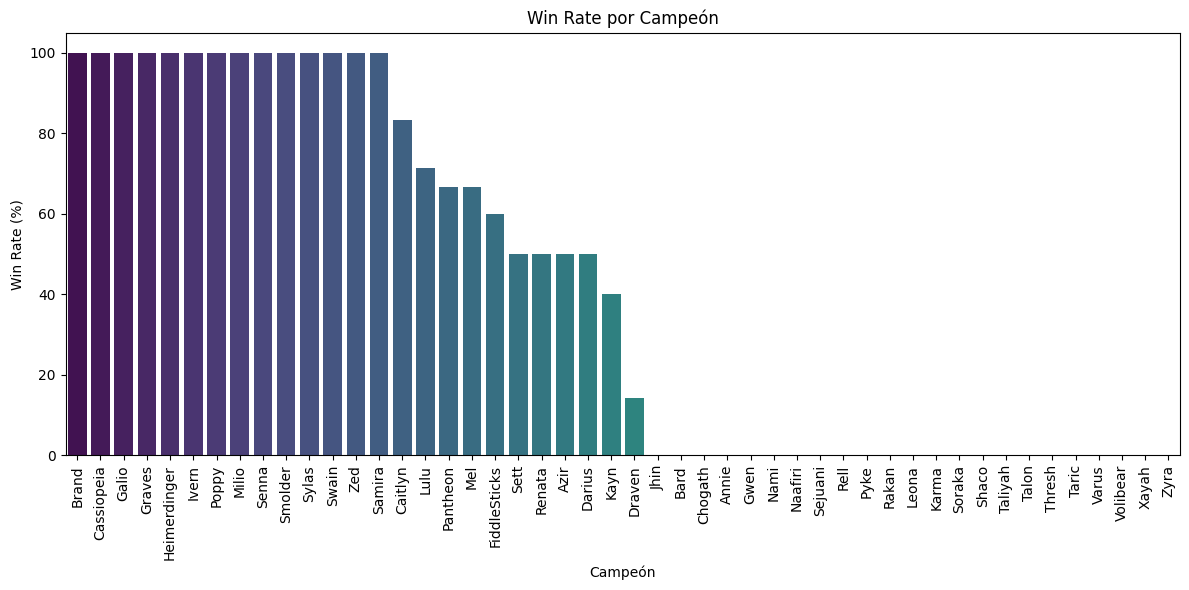

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reset index para que 'championName' sea una columna
champion_stats_reset = champion_stats.reset_index()

# Ordenar por win rate
champion_stats_sorted = champion_stats_reset.sort_values(by = 'win_rate', ascending=False)

# Tamaño del gráfico
plt.figure(figsize=(12, 6))

# Gráfico de barras
sns.barplot(data=champion_stats_sorted, x ='championName', y='win_rate', palette='viridis')

# Personalización
plt.title('Win Rate por Campeón')
plt.xlabel('Campeón')
plt.ylabel('Win Rate (%)')
plt.xticks(rotation=90)  # Rotar nombres para que no se encimen
plt.tight_layout()
plt.show()

<ipython-input-70-88497c5c6156>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_champs, x='championName', y='win_rate', palette='coolwarm')


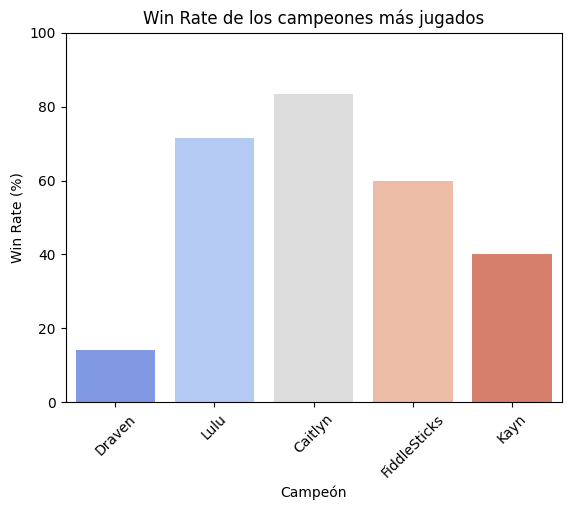

In [ ]:
top_champs = champion_stats_reset.sort_values(by='matches', ascending=False).head(5)

sns.barplot(data=top_champs, x='championName', y='win_rate', palette='coolwarm')
plt.title('Win Rate de los campeones más jugados')
plt.ylabel('Win Rate (%)')
plt.xlabel('Campeón')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.show()

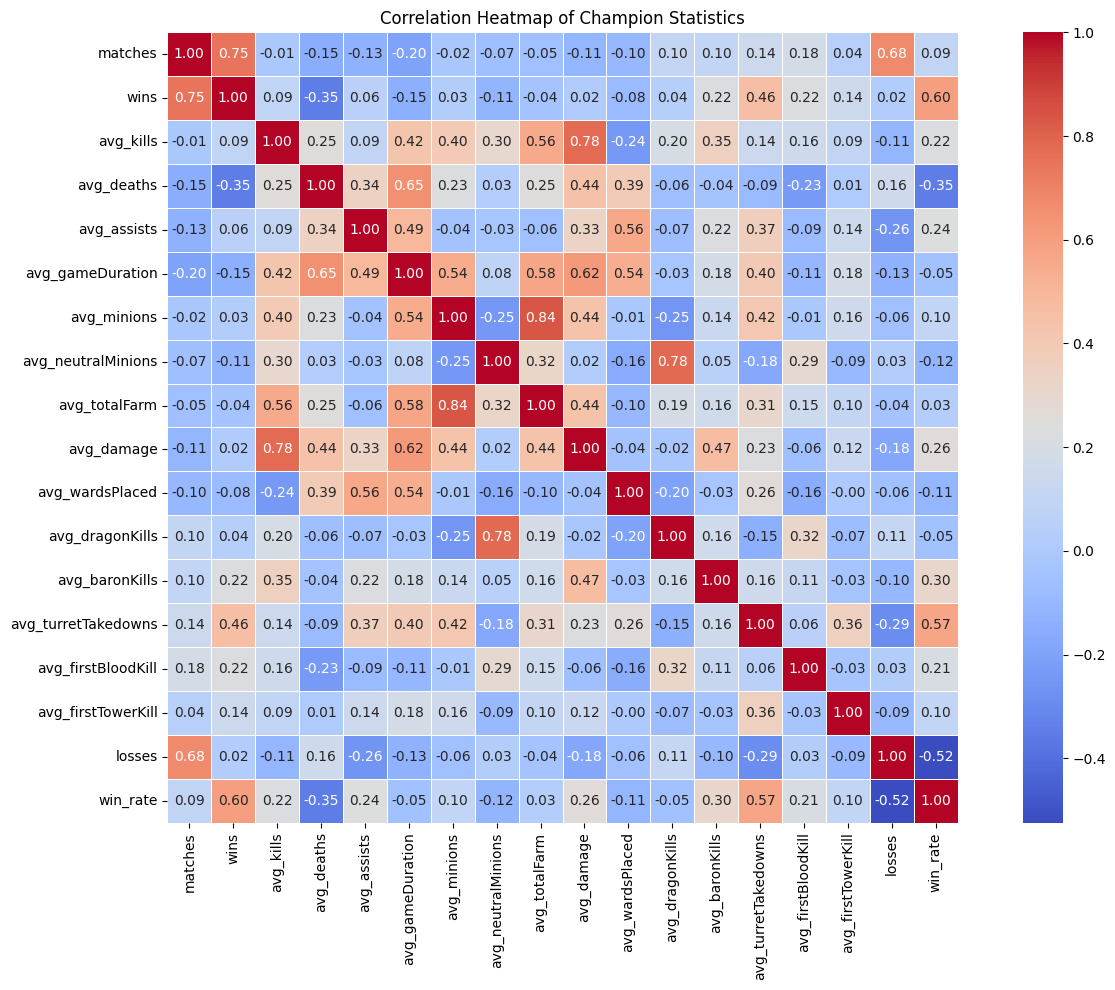

In [ ]:
# Matriz de Correlación para estadísticas grupales

# Seleccionar solo columnas numéricas de champion_stats
numeric_champion_stats = champion_stats.select_dtypes(include=[np.number])

# Verificar que haya columnas numéricas
if numeric_champion_stats.shape[1] > 0:
    # Calcular matriz de correlación
    corr = numeric_champion_stats.corr()

    # Graficar heatmap
    plt.figure(figsize=(14, 10))  # Tamaño del gráfico ajustable
    sns.heatmap(corr, annot = True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5)
    plt.title('Correlation Heatmap of Champion Statistics')
    plt.tight_layout()
    plt.show()
else:
    print("No hay columnas numéricas en champion_stats.")

In [ ]:
# Asegúrate de tener champion_stats_reset
champion_stats_reset = champion_stats.reset_index()

# Filtrar la fila de Lulu
lulu_row = champion_stats_reset[champion_stats_reset['championName'] == 'Lulu'].iloc[0]

print(f"Campeón seleccionado: {champion}")
print(f"- Partidas jugadas: {matches}")
print(f"- Win Rate: {win_rate:.2f}%")
print(f"- KDA promedio: {(avg_kills + avg_assists) / (avg_deaths if avg_deaths != 0 else 1):.2f}")

Campeón seleccionado: Lulu
- Partidas jugadas: 7
- Win Rate: 71.43%
- KDA promedio: 5.14


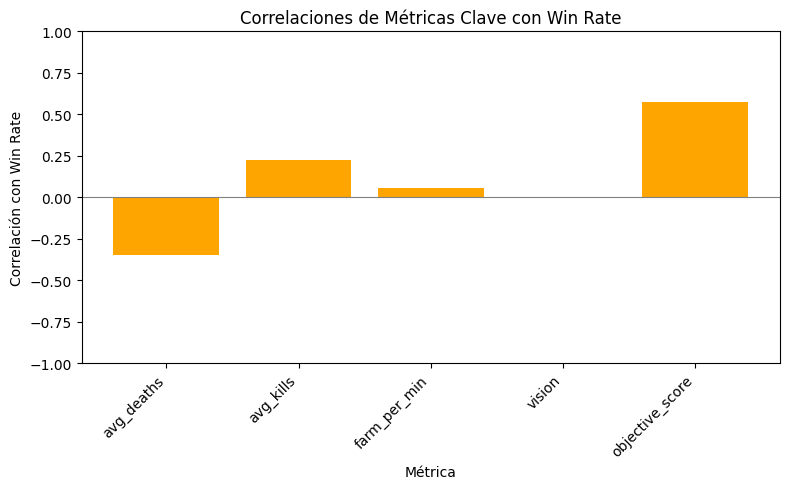

In [ ]:
try:
    # Calcular correlaciones entre win_rate y cada métrica clave
    corr_deaths = champion_stats['win_rate'].corr(champion_stats['avg_deaths'])
    corr_kills = champion_stats['win_rate'].corr(champion_stats['avg_kills'])
    # Calculamos farm_per_min si aún no existe
    if 'farm_per_min' not in champion_stats.columns:
        champion_stats['farm_per_min'] = champion_stats['avg_totalFarm'] / (champion_stats['avg_gameDuration'] / 60)
    corr_farm_min = champion_stats['win_rate'].corr(champion_stats['farm_per_min'])
    # Calculamos visión si aún no existe
    if 'vision' not in champion_stats.columns:
        champion_stats['vision'] = champion_stats['avg_wardsPlaced'] + champion_stats['avg_wardsDestroyed']
    corr_vision = champion_stats['win_rate'].corr(champion_stats['vision'])
    # Calculamos objective_score si aún no existe
    if 'objective_score' not in champion_stats.columns:
        champion_stats['objective_score'] = (
            champion_stats['avg_dragonKills'] +
            champion_stats['avg_baronKills'] +
            champion_stats['avg_turretTakedowns']
        )
    corr_obj = champion_stats['win_rate'].corr(champion_stats['objective_score'])
    # Calculamos early_impact si aún no existe
    if 'early_impact' not in champion_stats.columns:
        champion_stats['early_impact'] = (
            champion_stats['avg_firstBloodKill'] +
            champion_stats['avg_firstTowerKill'] +
            champion_stats['avg_firstDragon']
        )
    corr_early = champion_stats['win_rate'].corr(champion_stats['early_impact'])

    # Crear DataFrame con las correlaciones
    corr_data = pd.DataFrame({
        'Métrica': [
            'avg_deaths', 'avg_kills', 'farm_per_min',
            'vision', 'objective_score', 'early_impact'
        ],
        'Correlación': [
            corr_deaths, corr_kills, corr_farm_min,
            corr_vision, corr_obj, corr_early
        ]
    })

    # Graficar las correlaciones
    plt.figure(figsize=(8, 5))
    plt.bar(corr_data['Métrica'], corr_data['Correlación'], color='orange')
    plt.xlabel('Métrica')
    plt.ylabel('Correlación con Win Rate')
    plt.title('Correlaciones de Métricas Clave con Win Rate')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(-1, 1)
    plt.axhline(0, color='gray', linewidth=0.8)
    plt.tight_layout()
    plt.show()

except NameError:
    print("Error: El DataFrame 'champion_stats' no está definido. Asegúrate de haberlo calculado con antelación.")

In [ ]:
# Cálculo de KDA (evitando división por cero)
kda = (lulu['avg_kills'] + lulu['avg_assists']) / (lulu['avg_deaths'] if lulu['avg_deaths'] != 0 else np.nan)

# Control de visión (wards colocados + destruidos)
vision_score = lulu['avg_wardsPlaced'] + lulu['avg_wardsDestroyed']

# Participación en objetivos (dragones + barones + torres)
objective_score = (
    lulu['avg_dragonKills'] +
    lulu['avg_baronKills'] +
    lulu['avg_turretTakedowns']
)

# Impacto en early game (primeras kills/torre/dragon)
early_impact = (
    lulu['avg_firstBloodKill'] +
    lulu['avg_firstTowerKill'] +
    lulu['avg_firstDragon']
)

# Farm por minuto (avg_totalFarm dividido por duración en minutos)
farm_per_min = lulu['avg_totalFarm'] / (lulu['avg_gameDuration'] / 60)

# Mostrar resultados
print(f"Campeón: {lulu['championName']}")
print(f"- Partidas jugadas: {lulu['matches']}")
print(f"- Win Rate: {lulu['win_rate']:.2f}%")
print(f"- KDA promedio: {kda:.2f}")
print(f"- Farm por minuto: {farm_per_min:.2f}")
print(f"- Control de visión (wards): {vision_score:.2f}")
print(f"- Participación en objetivos: {objective_score:.2f}")
print(f"- Impacto early game: {early_impact:.2f}")

Campeón: Lulu
- Partidas jugadas: 7
- Win Rate: 71.43%
- KDA promedio: 5.14
- Farm por minuto: 0.79
- Control de visión (wards): nan
- Participación en objetivos: 3.71
- Impacto early game: nan


In [ ]:
print(f"Análisis del campeón seleccionado: {champion}")
print(f"- Partidas jugadas: {lulu['matches']}")
print(f"- Win Rate: {lulu['win_rate']:.2f}%")
print(f"- KDA promedio: {kda:.2f}")
print(f"- Farm por minuto: {farm_per_min:.2f}")
print(f"- Participación en objetivos: {objective_score:.2f}")

Análisis del campeón seleccionado: Lulu
- Partidas jugadas: 7
- Win Rate: 71.43%
- KDA promedio: 5.14
- Farm por minuto: 0.79
- Participación en objetivos: 3.71


In [ ]:
print("\nEvaluación rápida para Lulu:")

# Win Rate
if lulu['win_rate'] < 50:
    print("El win rate es bajo. Podrías revisar tu impacto en objetivos o tu visión.")
else:
    print("Buen win rate. Sigues ganando con este campeón.")

# KDA
if kda < 2:
    print("El KDA es bajo. Puede que mueras mucho o no asistas lo suficiente.")
else:
    print("Buen KDA. Manejas bien las peleas.")

# Farm por minuto
if farm_per_min < 6:
    print("El farming es bajo. Posiblemente pierdas oro o escalado.")
else:
    print("Buen farming. Aprovechas bien tu tiempo.")

# Participación en objetivos
if objective_score < 1:
    print("Participación baja en objetivos. Deberías priorizar dragones/barones.")
else:
    print("Participa en objetivos importantes.")


Evaluación rápida para Lulu:
Buen win rate. Sigues ganando con este campeón.
Buen KDA. Manejas bien las peleas.
El farming es bajo. Posiblemente pierdas oro o escalado.
Participa en objetivos importantes.


**Estadísticos clave**

In [ ]:
# Estadísticas básicas
desc_stats = champion_stats.describe()
print(desc_stats)

         matches       wins  avg_kills  avg_deaths  avg_assists  \
count  48.000000  48.000000  48.000000   48.000000    48.000000   
mean    1.895833   0.854167   4.813641    4.774851    10.619345   
std     1.587713   1.166730   4.233961    2.202308     6.362968   
min     1.000000   0.000000   0.000000    1.000000     0.000000   
25%     1.000000   0.000000   1.725000    3.000000     6.000000   
50%     1.000000   1.000000   3.875000    5.000000     9.250000   
75%     2.000000   1.000000   7.375000    6.000000    14.000000   
max     7.000000   5.000000  16.000000   10.000000    28.000000   

       avg_gameDuration  avg_minions  avg_neutralMinions  avg_totalFarm  \
count         48.000000    48.000000           48.000000      48.000000   
mean        1799.293105    83.234623           22.866964     106.101587   
std          529.418865    84.423936           48.505188      86.210743   
min          272.000000     0.000000            0.000000       0.000000   
25%         1506.0000

In [ ]:
summary = {
    'Promedio de Win Rate (%)': champion_stats['win_rate'].mean(),
    'Promedio de KDA': ((champion_stats['avg_kills'] + champion_stats['avg_assists']) / champion_stats['avg_deaths'].replace(0, np.nan)).mean(),
    'Promedio de farm/minuto': (champion_stats['avg_totalFarm'] / (champion_stats['avg_gameDuration'] / 60)).mean(),
    'Promedio de impacto en objetivos': (champion_stats['avg_dragonKills'] + champion_stats['avg_baronKills'] + champion_stats['avg_turretTakedowns']).mean()
}

for key, value in summary.items():
    print(f"{key}: {value:.2f}")


Promedio de Win Rate (%): 41.72
Promedio de KDA: 3.79
Promedio de farm/minuto: 3.34
Promedio de impacto en objetivos: 1.87


In [ ]:
# Filtrar campeones jugados más de X veces (por ejemplo, al menos 5 partidas)
frequent_champs = champion_stats_reset[champion_stats_reset['matches'] >= 5]

# Top 3 más jugados con mejor win rate
top_wins = frequent_champs.sort_values(by=['matches', 'win_rate'], ascending=[False, False]).head(3)

# Top 3 más jugados con peor win rate
low_wins = frequent_champs.sort_values(by=['matches', 'win_rate'], ascending=[False, True]).head(3)

print("Campeones más jugados con mejor Win Rate:")
print(top_wins[['championName', 'matches', 'win_rate']])

print("Campeones más jugados con peor Win Rate:")
print(low_wins[['championName', 'matches', 'win_rate']])


Campeones más jugados con mejor Win Rate:
   championName  matches   win_rate
19         Lulu        7  71.428571
8        Draven        7  14.285714
4       Caitlyn        6  83.333333
Campeones más jugados con peor Win Rate:
   championName  matches   win_rate
8        Draven        7  14.285714
19         Lulu        7  71.428571
4       Caitlyn        6  83.333333


In [ ]:
corr = champion_stats.corr()
print("Correlaciones con win_rate:")
print(corr['win_rate'].sort_values(ascending=False))

Correlaciones con win_rate:
win_rate               1.000000
wins                   0.596858
avg_turretTakedowns    0.572699
avg_baronKills         0.303717
avg_damage             0.256169
avg_assists            0.236995
avg_kills              0.222895
avg_firstBloodKill     0.205936
avg_minions            0.100189
avg_firstTowerKill     0.097915
matches                0.091623
avg_totalFarm          0.031700
avg_dragonKills       -0.048256
avg_gameDuration      -0.052433
avg_wardsPlaced       -0.108339
avg_neutralMinions    -0.118037
avg_deaths            -0.347127
losses                -0.524167
avg_wardsDestroyed          NaN
avg_firstBaron              NaN
avg_firstDragon             NaN
Name: win_rate, dtype: float64


<ipython-input-84-c0bce9e7016b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x='Valor', y='Categoría', palette='Blues_d')


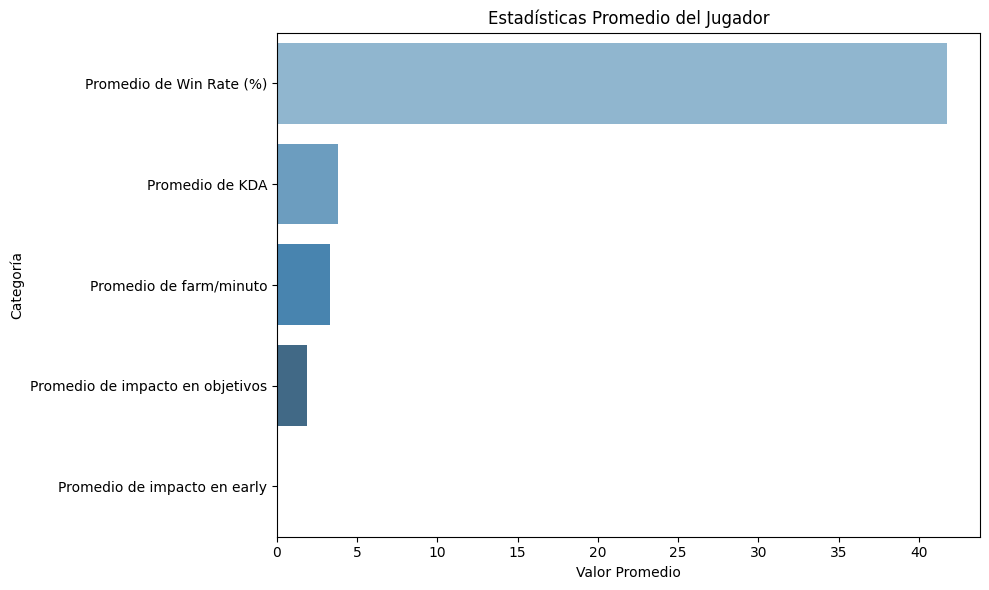

In [ ]:
summary_df = pd.DataFrame(list(summary.items()), columns=['Categoría', 'Valor'])

plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df, x='Valor', y='Categoría', palette='Blues_d')
plt.title('Estadísticas Promedio del Jugador')
plt.xlabel('Valor Promedio')
plt.ylabel('Categoría')
plt.tight_layout()
plt.show()

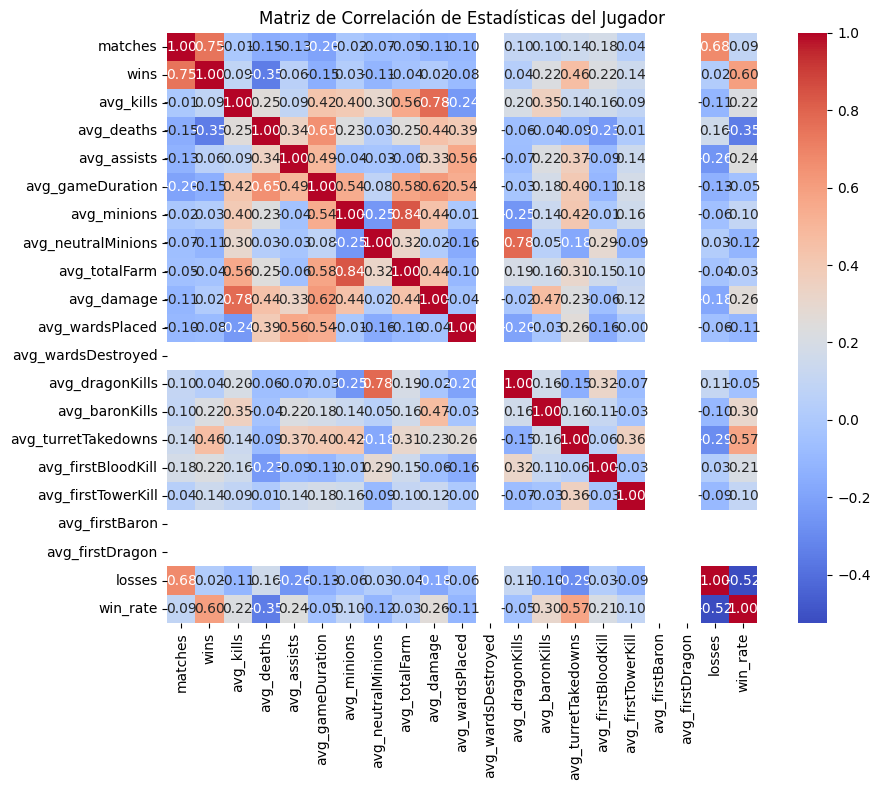

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Matriz de Correlación de Estadísticas del Jugador')
plt.tight_layout()
plt.show()